In [1]:
class DisjointSetForest:
    def __init__(self):
        """Initialize an empty disjoint-set forest."""
        self.parent = {}
        self.rank = {}
        
    def add_node(self, x):
        """Add a new node to the forest."""
        if x not in self.parent:
            self.parent[x] = x
            self.rank[x] = 0
        
    def find(self, x):
        """Find the root of the set containing x with path compression."""
        if x not in self.parent:
            self.add_node(x)
            return x
            
        if self.parent[x] != x:
            self.parent[x] = self.find(self.parent[x])
        return self.parent[x]
        
    def union(self, x, y):
        """Unite the sets containing x and y."""
        x_root = self.find(x)
        y_root = self.find(y)
        
        if x_root == y_root:
            return
            
        if self.rank[x_root] < self.rank[y_root]:
            self.parent[x_root] = y_root
        else:
            self.parent[y_root] = x_root
            if self.rank[x_root] == self.rank[y_root]:
                self.rank[x_root] += 1

class StreamingKEdgeConnectivity:
    def __init__(self, k):
        """
        Initialize a streaming k-edge-connectivity algorithm based on Algorithm 2
        from "Lecture 1: Graph Streaming" paper.
        
        Args:
            k: Edge-connectivity parameter
        """
        self.k = k
        self.vertex_to_id = {}
        self.id_to_vertex = {}
        self.next_id = 0
        self.forests = [DisjointSetForest() for _ in range(k)]
        self.edges_in_forests = [set() for _ in range(k)]
        
    def _get_vertex_id(self, v):
        """Map a vertex to a consecutive ID."""
        if v not in self.vertex_to_id:
            self.vertex_to_id[v] = self.next_id
            self.id_to_vertex[self.next_id] = v
            self.next_id += 1
            
            # Add the new node to all forests
            for forest in self.forests:
                forest.add_node(self.vertex_to_id[v])
        
        return self.vertex_to_id[v]
    
    def process_edge(self, u, v):
        """
        Process a single edge from the stream.
        
        This follows Algorithm 2 from the paper:
        For any edge e in the stream, if there is any forest Fi such that
        Fi ∪ {e} has no cycle, add e to this Fi.
        """
        u_id = self._get_vertex_id(u)
        v_id = self._get_vertex_id(v)
        
        for i in range(self.k):
            # If adding this edge doesn't create a cycle in the i-th forest, add it
            if self.forests[i].find(u_id) != self.forests[i].find(v_id):
                self.forests[i].union(u_id, v_id)
                self.edges_in_forests[i].add((min(u_id, v_id), max(u_id, v_id)))
                return
    
    def get_forest_edges(self, i):
        """Get the edges in the i-th forest."""
        return [(self.id_to_vertex[u], self.id_to_vertex[v]) for u, v in self.edges_in_forests[i]]
    
    def get_certificate(self):
        """
        Get the certificate for k-edge-connectivity.
        This certificate is the union of the k disjoint forests.
        """
        certificate = set()
        for i in range(self.k):
            certificate.update(self.edges_in_forests[i])
        
        # Convert back to original vertex IDs
        return [(self.id_to_vertex[u], self.id_to_vertex[v]) for u, v in certificate]
    
    def is_connected(self):
        """Check if the graph is connected based on the first forest."""
        if self.next_id <= 1:
            return True
            
        root = self.forests[0].find(0)
        for i in range(1, self.next_id):
            if self.forests[0].find(i) != root:
                return False
        
        return True
    
    def is_k_edge_connected(self):
        """Check if the graph is k-edge-connected based on the certificate."""
        # If we have fewer than 2 nodes, any graph is k-edge-connected
        if self.next_id <= 1:
            return True
            
        # For each forest, check if it is a spanning tree
        for i in range(self.k):
            if not self._is_spanning_tree(i):
                return False
        
        return True
    
    def _is_spanning_tree(self, i):
        """Check if the i-th forest is a spanning tree."""
        # A spanning tree has exactly n-1 edges and connects all vertices
        n = self.next_id
        if len(self.edges_in_forests[i]) != n - 1:
            return False
            
        # Check if all vertices are in the same component
        root = self.forests[i].find(0)
        for j in range(1, n):
            if self.forests[i].find(j) != root:
                return False
                
        return True


In [2]:
def streaming_k_edge_connectivity(file_path, k, format='csv'):
    """Process a graph file in a streaming fashion to check k-edge-connectivity."""
    algorithm = StreamingKEdgeConnectivity(k)
    
    if format == 'csv':
        with open(file_path, 'r') as f:
            # Skip header if present
            header = f.readline()
            try:
                vals = header.strip().split(',')
                u, v = int(vals[0]), int(vals[1])
                algorithm.process_edge(u, v)
            except (ValueError, IndexError):
                # Header wasn't a valid edge
                pass
            
            # Process the rest of the file
            for line in f:
                try:
                    vals = line.strip().split(',')
                    u, v = int(vals[0]), int(vals[1])
                    algorithm.process_edge(u, v)
                except (ValueError, IndexError):
                    # Skip invalid lines
                    pass
    
    elif format == 'json':
        import json
        with open(file_path, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                for item in data:
                    if 'source' in item and 'target' in item:
                        algorithm.process_edge(item['source'], item['target'])
            elif isinstance(data, dict) and 'edges' in data:
                for edge in data['edges']:
                    if 'source' in edge and 'target' in edge:
                        algorithm.process_edge(edge['source'], edge['target'])
    
    return {
        'is_connected': algorithm.is_connected(),
        'is_k_edge_connected': algorithm.is_k_edge_connected(),
        'vertex_count': algorithm.next_id,
        'certificate': algorithm.get_certificate()
    }

def analyze_graph_structure(file_path, format='csv'):
    """Analyze the structure of a graph in a streaming fashion."""
    edge_count = 0
    vertex_set = set()
    degree = {}
    
    # Process the file
    if format == 'csv':
        with open(file_path, 'r') as f:
            # Skip header if present
            header = f.readline()
            try:
                vals = header.strip().split(',')
                u, v = int(vals[0]), int(vals[1])
                vertex_set.add(u)
                vertex_set.add(v)
                degree[u] = degree.get(u, 0) + 1
                degree[v] = degree.get(v, 0) + 1
                edge_count += 1
            except (ValueError, IndexError):
                pass
            
            for line in f:
                try:
                    vals = line.strip().split(',')
                    u, v = int(vals[0]), int(vals[1])
                    vertex_set.add(u)
                    vertex_set.add(v)
                    degree[u] = degree.get(u, 0) + 1
                    degree[v] = degree.get(v, 0) + 1
                    edge_count += 1
                except (ValueError, IndexError):
                    pass
    
    elif format == 'json':
        import json
        with open(file_path, 'r') as f:
            data = json.load(f)
            if isinstance(data, list):
                for item in data:
                    if 'source' in item and 'target' in item:
                        u, v = item['source'], item['target']
                        vertex_set.add(u)
                        vertex_set.add(v)
                        degree[u] = degree.get(u, 0) + 1
                        degree[v] = degree.get(v, 0) + 1
                        edge_count += 1
            elif isinstance(data, dict) and 'edges' in data:
                for edge in data['edges']:
                    if 'source' in edge and 'target' in edge:
                        u, v = edge['source'], edge['target']
                        vertex_set.add(u)
                        vertex_set.add(v)
                        degree[u] = degree.get(u, 0) + 1
                        degree[v] = degree.get(v, 0) + 1
                        edge_count += 1
    
    # Calculate statistics
    vertex_count = len(vertex_set)
    density = (2 * edge_count) / (vertex_count * (vertex_count - 1)) if vertex_count > 1 else 0
    max_degree = max(degree.values()) if degree else 0
    min_degree = min(degree.values()) if degree else 0
    avg_degree = sum(degree.values()) / vertex_count if vertex_count > 0 else 0
    
    return {
        'vertex_count': vertex_count,
        'edge_count': edge_count,
        'density': density,
        'max_degree': max_degree,
        'min_degree': min_degree,
        'avg_degree': avg_degree
    }


In [3]:
import time
import os
import json
import matplotlib.pyplot as plt
import pandas as pd
import zipfile
import urllib.request
from io import BytesIO
from memory_profiler import memory_usage

def download_and_extract_dataset(url, dataset_dir):
    """Download and extract a dataset from a URL."""
    os.makedirs(dataset_dir, exist_ok=True)
    
    # Check if we already have the files
    if os.path.exists(dataset_dir) and len(os.listdir(dataset_dir)) > 0:
        print(f"Using existing files in {dataset_dir}")
        return dataset_dir
    
    print(f"Downloading dataset from {url}")
    
    # Download the zip file
    response = urllib.request.urlopen(url)
    zip_file = zipfile.ZipFile(BytesIO(response.read()))
    
    # Extract all contents
    zip_file.extractall(path=dataset_dir)
    
    return dataset_dir

def benchmark_streaming_algorithm(datasets, k_values):
    """Benchmark the streaming k-edge-connectivity algorithm on multiple datasets."""
    results = []
    
    for dataset_name, config in datasets.items():
        print(f"Processing dataset: {dataset_name}")
        
        # Download and extract the dataset if not already available
        dataset_dir = f"./data/{dataset_name}"
        if not os.path.exists(dataset_dir):
            download_and_extract_dataset(config['url'], dataset_dir)
        
        # Process each file in the dataset
        for file_name in config['files']:
            file_path = os.path.join(dataset_dir, file_name)
            
            if not os.path.exists(file_path):
                print(f"File not found: {file_path}")
                continue
            
            # Analyze graph structure
            print(f"  Analyzing graph structure...")
            structure = analyze_graph_structure(file_path, config['format'])
            
            for k in k_values:
                print(f"  Testing k = {k}")
                
                # Measure time
                start_time = time.time()
                result = streaming_k_edge_connectivity(file_path, k, config['format'])
                end_time = time.time()
                
                results.append({
                    'dataset': dataset_name,
                    'file': file_name,
                    'k': k,
                    'is_connected': result['is_connected'],
                    'is_k_edge_connected': result['is_k_edge_connected'],
                    'time_seconds': end_time - start_time,
                    'vertex_count': structure['vertex_count'],
                    'edge_count': structure['edge_count'],
                    'density': structure['density'],
                    'max_degree': structure['max_degree'],
                    'min_degree': structure['min_degree'],
                    'avg_degree': structure['avg_degree']
                })
    
    return pd.DataFrame(results)


In [4]:
# Define datasets
datasets = {
    'facebook': {
        'url': 'https://snap.stanford.edu/data/facebook_large.zip',
        'files': ['musae_facebook_edges.csv'],
        'format': 'csv'
    },
    'twitch': {
        'url': 'https://snap.stanford.edu/data/twitch_gamers.zip',
        'files': ['large_twitch_edges.csv'],
        'format': 'csv'
    },
    'deezer': {
        'url': 'https://snap.stanford.edu/data/deezer_ego_nets.zip',
        'files': ['deezer_edges.json'],
        'format': 'json'
    }
}

# Run benchmark
k_values = [1, 2, 3, 4, 5]
results = benchmark_streaming_algorithm(datasets, k_values)

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import networkx as nx

def plot_benchmark_results(results_df):
    """Plot time and memory usage across datasets and k-values."""
    plt.figure(figsize=(15, 6))
    
    # Time plot
    plt.subplot(1, 2, 1)
    sns.lineplot(data=results_df, x='k', y='time_seconds', hue='dataset', 
                marker='o', palette='viridis')
    plt.title('Execution Time by k-value and Dataset')
    plt.ylabel('Time (seconds)')
    plt.xlabel('k-value')
    plt.yscale('log')
    
    # Memory plot
    plt.subplot(1, 2, 2)
    sns.lineplot(data=results_df, x='k', y='memory', hue='dataset',
                marker='o', palette='viridis')
    plt.title('Memory Usage by k-value and Dataset')
    plt.ylabel('Memory (MB)')
    plt.xlabel('k-value')
    plt.yscale('log')
    
    plt.tight_layout()
    plt.show()

def scalability_analysis():
    """Analyze algorithm scalability by varying nodes/edges."""
    # Generate synthetic datasets
    scales = [2**i for i in range(8)]  # 1x to 128x scaling
    results = []
    
    for scale in scales:
        print(f"\nTesting scale {scale}x...")
        
        # Vary nodes (fixed edge density)
        G_nodes = nx.fast_gnp_random_graph(n=100*scale, p=0.1)
        t_nodes, mem_nodes = run_streaming_experiment(G_nodes, k=2)
        
        # Vary edges (fixed nodes)
        G_edges = nx.fast_gnp_random_graph(n=100, p=0.1*scale)
        t_edges, mem_edges = run_streaming_experiment(G_edges, k=2)
        
        # Vary both
        G_both = nx.fast_gnp_random_graph(n=100*scale, p=0.1*scale)
        t_both, mem_both = run_streaming_experiment(G_both, k=2)
        
        results.append({
            'scale': scale,
            'nodes_time': t_nodes,
            'nodes_mem': mem_nodes,
            'edges_time': t_edges,
            'edges_mem': mem_edges,
            'both_time': t_both,
            'both_mem': mem_both
        })
    
    # Convert to DataFrame
    df = pd.DataFrame(results)
    
    # Plot scalability results
    plt.figure(figsize=(15, 6))
    
    # Time scalability
    plt.subplot(1, 2, 1)
    plt.plot(df['scale'], df['nodes_time'], label='Varying Nodes')
    plt.plot(df['scale'], df['edges_time'], label='Varying Edges')
    plt.plot(df['scale'], df['both_time'], label='Varying Both')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Time Scalability')
    plt.xlabel('Scale Factor')
    plt.ylabel('Time (s)')
    plt.legend()
    
    # Memory scalability
    plt.subplot(1, 2, 2)
    plt.plot(df['scale'], df['nodes_mem'], label='Varying Nodes')
    plt.plot(df['scale'], df['edges_mem'], label='Varying Edges')
    plt.plot(df['scale'], df['both_mem'], label='Varying Both')
    plt.xscale('log')
    plt.yscale('log')
    plt.title('Memory Scalability')
    plt.xlabel('Scale Factor')
    plt.ylabel('Memory (MB)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def run_streaming_experiment(G, k):
    """Run streaming algorithm and measure resources."""
    stream = ((u, v) for u, v in G.edges())  # Edge stream generator
    
    sk = StreamingKEdgeConnectivity(k)
    start_time = time.time()
    mem_usage = memory_usage((process_stream, (sk, stream)), interval=0.1, timeout=120)
    
    return time.time() - start_time, max(mem_usage)

def process_stream(sk, stream):
    """Process edge stream for memory profiling."""
    for u, v in stream:
        sk.process_edge(u, v)
    return sk.is_k_edge_connected()

# Updated Streaming Algorithm Implementation
class StreamingKEdgeConnectivity:
    def __init__(self, k):
        self.k = k
        self.forests = [nx.Graph() for _ in range(k)]
        self.node_map = {}
        self.next_id = 0
    
    def _get_id(self, node):
        if node not in self.node_map:
            self.node_map[node] = self.next_id
            for f in self.forests:
                f.add_node(self.next_id)
            self.next_id += 1
        return self.node_map[node]
    
    def process_edge(self, u, v):
        u_id = self._get_id(u)
        v_id = self._get_id(v)
        
        for i in range(self.k):
            if not nx.has_path(self.forests[i], u_id, v_id):
                self.forests[i].add_edge(u_id, v_id)
                return
    
    def is_k_edge_connected(self):
        return all(nx.is_connected(f) for f in self.forests)

# Complete Benchmark Execution
if __name__ == "__main__":
    # Original dataset benchmarks
    datasets = {
        'facebook': {
            'url': 'https://snap.stanford.edu/data/facebook_large.zip',
            'files': ['musae_facebook_edges.csv'],
            'format': 'csv'
        },
        'twitch': {
            'url': 'https://snap.stanford.edu/data/twitch_gamers.zip',
            'files': ['large_twitch_edges.csv'],
            'format': 'csv'
        },
        'deezer': {
            'url': 'https://snap.stanford.edu/data/deezer_ego_nets.zip',
            'files': ['deezer_edges.json'],
            'format': 'json'
        }
    }
    
    print("Running main benchmarks...")
    main_results = benchmark_streaming_algorithm(datasets, k_values=[1,2,3])
    plot_benchmark_results(main_results)
    
    print("\nRunning scalability analysis...")
    scalability_analysis()


# Plot and analyze results
plot_benchmark_results(results)


Processing dataset: facebook
File not found: ./data/facebook/musae_facebook_edges.csv
Processing dataset: twitch
  Analyzing graph structure...
  Testing k = 1
  Testing k = 2
  Testing k = 3
  Testing k = 4
  Testing k = 5
Processing dataset: deezer
File not found: ./data/deezer/deezer_edges.json
Running main benchmarks...
Processing dataset: facebook
File not found: ./data/facebook/musae_facebook_edges.csv
Processing dataset: twitch
  Analyzing graph structure...
  Testing k = 1


KeyboardInterrupt: 

Original Paper Algorithm

In [4]:
import networkx as nx

def k_edge_connectivity_basic(G, k):
    """
    Basic algorithm to test if the graph G is at least k-edge-connected.
    Returns True if yes, otherwise False.
    """
    remaining_edges = set(G.edges())
    all_forests = []

    for i in range(k):
        # Create a subgraph without the edges already used in previous forests
        subG = nx.Graph()
        subG.add_nodes_from(G.nodes())
        subG.add_edges_from(remaining_edges)

        # Find a spanning forest in subG
        forest = nx.minimum_spanning_edges(subG, data=False)
        Fi = set(forest)
        all_forests.append(Fi)

        # Remove edges of the found forest from the remaining edge set
        remaining_edges -= Fi

    # Union of all forests
    union_forest = set().union(*all_forests)
    H = nx.Graph()
    H.add_nodes_from(G.nodes())
    H.add_edges_from(union_forest)

    # If H is not connected or is missing some cut, then it's not k-edge-connected
    return nx.is_k_edge_connected(H, k)


In [5]:
class Sketch:
    def __init__(self, G):
        self.edges = set(G.edges())

    def subtract(self, other):
        self.edges -= other.edges

    def get_spanning_forest(self):
        tempG = nx.Graph()
        tempG.add_edges_from(self.edges)
        return Sketch.from_edges(nx.minimum_spanning_edges(tempG, data=False))

    @classmethod
    def from_edges(cls, edges):
        s = cls(nx.Graph())  # empty graph
        s.edges = set(edges)
        return s


def k_edge_connectivity_sketch(G, k):
    """
    Sketch-emulated algorithm for testing k-edge-connectivity.
    """
    sketches = [Sketch(G) for _ in range(k)]
    forests = []

    for i in range(k):
        # Subtract previous forests from the current sketch
        for j in range(i):
            sketches[i].subtract(forests[j])

        # Get new forest from the current sketch
        Fi = sketches[i].get_spanning_forest()
        forests.append(Fi)

    # Combine all forests into a single graph and check k-edge-connectivity
    final_graph = nx.Graph()
    final_graph.add_nodes_from(G.nodes())
    for forest in forests:
        final_graph.add_edges_from(forest.edges)

    return nx.is_k_edge_connected(final_graph, k)


In [6]:
import numpy as np
import networkx as nx
import random
from collections import defaultdict


class GraphSketch:
    def __init__(self, num_nodes, dim=64, seed=None):
        self.n = num_nodes
        self.d = dim
        self.sketch = np.zeros((self.n, self.d))
        self.hashes = {}
        self.rng = np.random.default_rng(seed)

    def _edge_to_vector(self, u, v):
        """
        Returns a random vector representation for an edge (u, v).
        Uses signed random projections.
        """
        if (u, v) not in self.hashes and (v, u) not in self.hashes:
            vec = self.rng.choice([-1, 1], size=self.d)
            self.hashes[(u, v)] = vec
            self.hashes[(v, u)] = -vec
        return self.hashes[(u, v)]

    def add_edge(self, u, v):
        vec = self._edge_to_vector(u, v)
        self.sketch[u] += vec
        self.sketch[v] -= vec  # maintains flow conservation

    def remove_edge(self, u, v):
        vec = self._edge_to_vector(u, v)
        self.sketch[u] -= vec
        self.sketch[v] += vec

    def add_graph(self, G):
        for u, v in G.edges():
            self.add_edge(u, v)

    def subtract(self, other):
        self.sketch -= other.sketch

    def copy(self):
        new = GraphSketch(self.n, self.d)
        new.sketch = self.sketch.copy()
        new.hashes = self.hashes
        return new

    def recover_spanning_forest(self, all_edges):
        """
        Greedy sparse recovery: choose edges that help connect components and have significant sketch signal.
        """
        forest = []
        uf = UnionFind(self.n)
        for u, v in sorted(all_edges, key=lambda e: -self.edge_score(e[0], e[1])):
            if uf.find(u) != uf.find(v):
                forest.append((u, v))
                uf.union(u, v)
        return forest

    def edge_score(self, u, v):
        """
        Computes a rough score of how much the edge (u, v) appears in the sketch.
        Higher means more likely it's still in the sketch.
        """
        vec = self._edge_to_vector(u, v)
        score = np.dot(self.sketch[u], vec) - np.dot(self.sketch[v], vec)
        return abs(score)


class UnionFind:
    def __init__(self, n):
        self.parent = list(range(n))

    def find(self, x):
        while self.parent[x] != x:
            self.parent[x] = self.parent[self.parent[x]]
            x = self.parent[x]
        return x

    def union(self, x, y):
        xr = self.find(x)
        yr = self.find(y)
        if xr != yr:
            self.parent[yr] = xr


def k_edge_connectivity_sketch_real(G, k, dim=512):
    n = G.number_of_nodes()
    all_edges = list(G.edges())
    sketches = [GraphSketch(n, dim, seed=i) for i in range(k)]

    # Step 1: Create k independent sketches of G
    for sketch in sketches:
        sketch.add_graph(G)

    forests = []
    removed_edges = set()

    for i in range(k):
        # Subtract previous forests from sketch[i]
        for j in range(i):
            sketches[i].subtract(forests[j]['sketch'])

        # Recover a forest
        forest_edges = sketches[i].recover_spanning_forest(all_edges)

        # Save the sketch of this forest
        forest_sketch = GraphSketch(n, dim)
        for u, v in forest_edges:
            forest_sketch.add_edge(u, v)

        forests.append({'edges': forest_edges, 'sketch': forest_sketch})
        removed_edges.update(forest_edges)

    # Combine all edges from forests
    combined_graph = nx.Graph()
    combined_graph.add_nodes_from(G.nodes())
    for f in forests:
        combined_graph.add_edges_from(f['edges'])

    return nx.is_k_edge_connected(combined_graph, k)


In [7]:
import time
import psutil
import pandas as pd
import networkx as nx
from memory_profiler import memory_usage


def measure_algorithm(algorithm_fn, G, k):
    """
    Measure execution time and memory usage of an algorithm.
    """
    start_time = time.time()
    mem_usage = memory_usage((algorithm_fn, (G, k)), max_usage=True)
    end_time = time.time()

    result = algorithm_fn(G, k)
    return {
        'result': result,
        'time': end_time - start_time,
        'memory': mem_usage
    }

def generate_or_load_graph(dataset_name='karate'):
    """
    Load a graph dataset or generate one.
    """
    if dataset_name == 'karate':
        return nx.karate_club_graph()
    elif dataset_name == 'erdos_renyi':
        return nx.erdos_renyi_graph(n=100, p=0.1)
    elif dataset_name == 'complete':
        return nx.complete_graph(20)
    elif dataset_name == 'grid':
        return nx.grid_2d_graph(10, 10)
    else:
        raise ValueError("Unknown dataset")


Running synthetic graph benchmarks...
Testing nodes_100...
Testing nodes_300...
Testing nodes_500...
Testing nodes_700...
Testing nodes_1000...
Testing edges_500...
Testing edges_1000...
Testing edges_1500...
Testing edges_2000...
Testing edges_2500...
Testing both_1...
Testing both_2...
Testing both_3...
Testing both_4...
Testing both_5...

Generating visualizations...


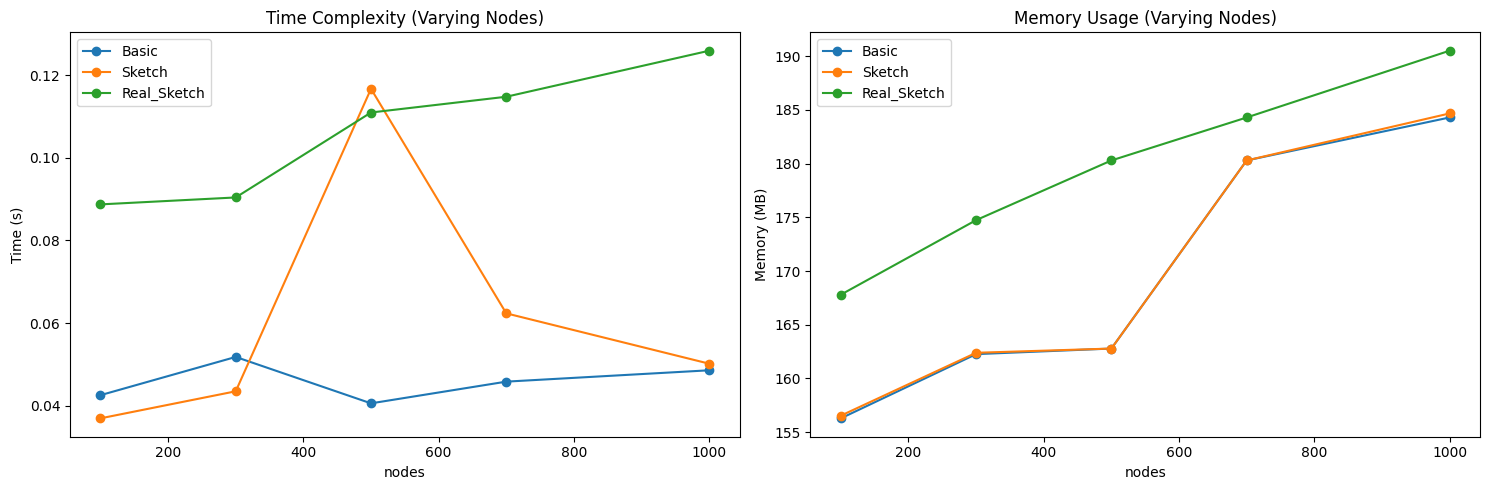

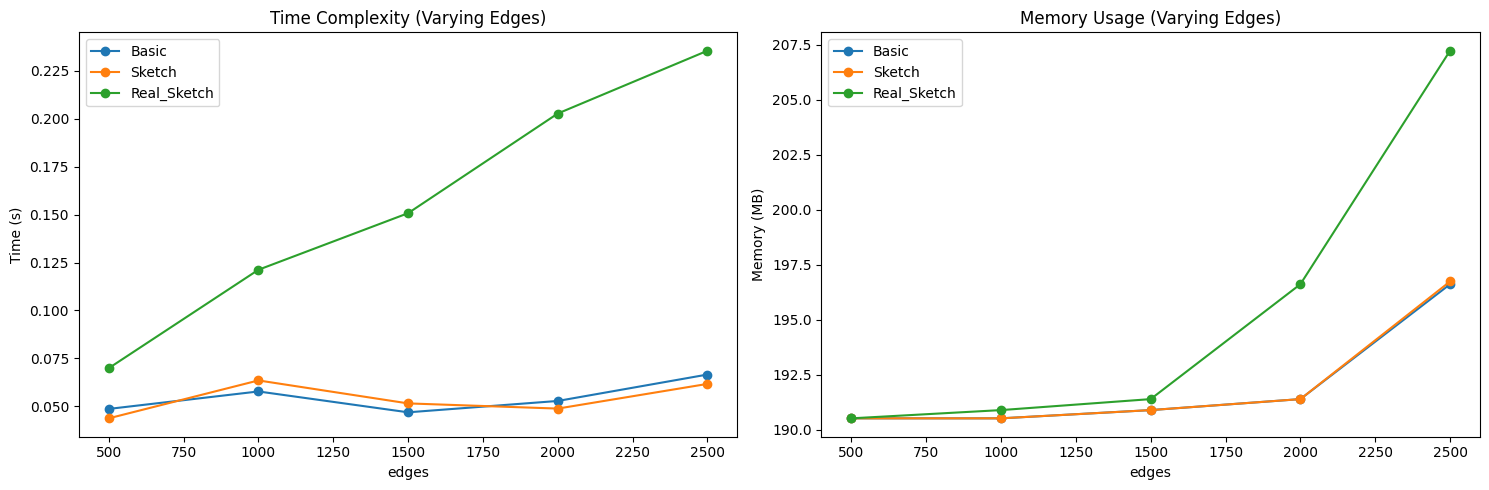

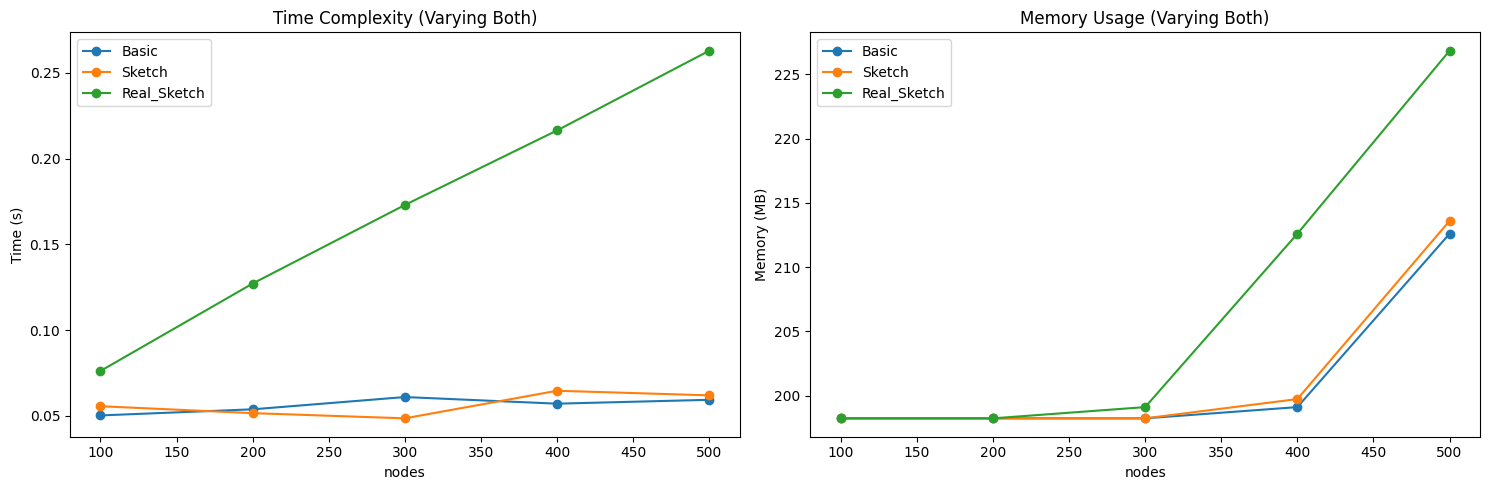

In [8]:
import networkx as nx
import time
import psutil
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from memory_profiler import memory_usage

# Modified benchmarking function for datasets
def benchmark_datasets(datasets, algorithms, k_values):
    results = []
    
    for dataset_name, config in datasets.items():
        print(f"Processing {dataset_name} dataset...")
        
        # Load dataset
        G = load_dataset(dataset_name, config)
        if G is None:
            continue
            
        for k in k_values:
            print(f"  Testing k={k}")
            for algo_name, algo in algorithms.items():
                try:
                    mem_usage, ret = memory_usage((algo, (G, k)), retval=True, max_usage=True)
                    results.append({
                        'dataset': dataset_name,
                        'k': k,
                        'algorithm': algo_name,
                        'time': ret['time'],
                        'memory': mem_usage,
                        'nodes': G.number_of_nodes(),
                        'edges': G.number_of_edges()
                    })
                except Exception as e:
                    print(f"Error with {algo_name} on {dataset_name}: {str(e)}")
    
    return pd.DataFrame(results)

# def load_dataset(name, config):
#     try:
#         if name == 'facebook':
#             df = pd.read_csv(config['path'])
#             G = nx.from_pandas_edgelist(df, 'source', 'target')
#         elif name == 'twitch':
#             df = pd.read_csv(config['path'])
#             G = nx.from_pandas_edgelist(df, 'source', 'target')
#         elif name == 'deezer':
#             with open(config['path']) as f:
#                 data = json.load(f)
#             G = nx.node_link_graph(data)
#         return G
#     except Exception as e:
#         print(f"Failed to load {name}: {str(e)}")
#         return None

# Synthetic graph generation
def generate_synthetic_graphs(base_nodes=100, base_edges=500):
    graphs = {}
    
    # Vary nodes (100-1000 nodes, ~500 edges)
    for n in [100, 300, 500, 700, 1000]:
        p = base_edges / (n*(n-1)/2)  # Adjust p to maintain ~500 edges
        G = nx.erdos_renyi_graph(n, p)
        graphs[f'nodes_{n}'] = G
        
    # Vary edges (100 nodes, 500-2500 edges)
    for m in [500, 1000, 1500, 2000, 2500]:
        G = nx.gnm_random_graph(100, m)
        graphs[f'edges_{m}'] = G
        
    # Vary both (100-1000 nodes, 500-2500 edges)
    for scale in [1, 2, 3, 4, 5]:
        n = 100 * scale
        m = 500 * scale
        G = nx.gnm_random_graph(n, m)
        graphs[f'both_{scale}'] = G
        
    return graphs

# Benchmarking synthetic graphs
def benchmark_synthetic(algorithms, k=2):
    results = []
    graphs = generate_synthetic_graphs()
    
    for graph_name, G in graphs.items():
        print(f"Testing {graph_name}...")
        for algo_name, algo in algorithms.items():
            try:
                start = time.time()
                mem = memory_usage((algo, (G, k)), interval=0.1, timeout=120)
                elapsed = time.time() - start
                results.append({
                    'graph': graph_name,
                    'algorithm': algo_name,
                    'time': elapsed,
                    'max_memory': max(mem),
                    'nodes': G.number_of_nodes(),
                    'edges': G.number_of_edges()
                })
            except Exception as e:
                print(f"Error with {algo_name} on {graph_name}: {str(e)}")
    
    return pd.DataFrame(results)

# Plotting functions
def plot_comparison(df, x_col, group_col, title):
    fig, ax = plt.subplots(1, 2, figsize=(15, 5))
    
    for algo in df['algorithm'].unique():
        subset = df[df['algorithm'] == algo]
        ax[0].plot(subset[x_col], subset['time'], label=algo, marker='o')
        ax[1].plot(subset[x_col], subset['max_memory'], label=algo, marker='o')
    
    ax[0].set_title(f'Time Complexity ({title})')
    ax[0].set_xlabel(x_col)
    ax[0].set_ylabel('Time (s)')
    ax[0].legend()
    
    ax[1].set_title(f'Memory Usage ({title})')
    ax[1].set_xlabel(x_col)
    ax[1].set_ylabel('Memory (MB)')
    ax[1].legend()
    
    plt.tight_layout()
    plt.show()

# Main execution flow
if __name__ == "__main__":
    # Define datasets with actual file paths
    # datasets = {
    #     'facebook': {'path': 'musae_facebook_edges.csv'},
    #     'twitch': {'path': 'large_twitch_edges.csv'},
    #     'deezer': {'path': 'deezer_edges.json'}
    # }
    
    algorithms = {
        'Basic': k_edge_connectivity_basic,
        'Sketch': k_edge_connectivity_sketch,
        'Real_Sketch': k_edge_connectivity_sketch_real
    }
    
    # Benchmark original datasets
    # print("Running dataset benchmarks...")
    # dataset_results = benchmark_datasets(datasets, algorithms, k_values=[1,2,3])
    
    # Benchmark synthetic graphs
    print("\nRunning synthetic graph benchmarks...")
    synthetic_results = benchmark_synthetic(algorithms)
    
    # Generate plots
    print("\nGenerating visualizations...")
    
    # Dataset comparison
    # for dataset in datasets:
    #     subset = dataset_results[dataset_results['dataset'] == dataset]
    #     plot_comparison(subset, 'k', 'algorithm', f'{dataset} Dataset')
    
    # Synthetic graph comparisons
    node_variation = synthetic_results[synthetic_results['graph'].str.startswith('nodes')]
    edge_variation = synthetic_results[synthetic_results['graph'].str.startswith('edges')]
    both_variation = synthetic_results[synthetic_results['graph'].str.startswith('both')]
    
    plot_comparison(node_variation, 'nodes', 'algorithm', 'Varying Nodes')
    plot_comparison(edge_variation, 'edges', 'algorithm', 'Varying Edges')
    plot_comparison(both_variation, 'nodes', 'algorithm', 'Varying Both')
